# Capston Project 2 - The Financial Performance of the ESG Funds
# Data Preprocessing and Modeling Exploration
By Tingyin Xiao

<a id="0"></a> <br>
 # Table of Contents  

* [1. Introduction](#1)
* [2. Importing the Dependencies](#2)
* [3. Importing the Data](#3)
* [4  Fitting the ARIMA Model on One of the Time Series](#4)
* [5  Fitting the Random Forest Model with Features](#5)
    * [5.1. Preprocessing the Categorical Features](#5.1)
    * [5.2. Preparing the Numeric Features for Modeling](#5.2)
    * [5.3. Model Fitting, Cross-validation, and Feature Selection](#5.3)
* [6. Summary](#6)

<a id="1"></a> 
## Introduction

Before the final step of modeling, we need to prepare the data first. The feature engineering techniques including tranforming the categorical features and scaling the numeric features will be applied. Also, we will handle the missing data in the categorical features and numeric features, respectively. As our data consist of thousands of time series, the time dependency is important in the target and features. To explore and examplify how the time dependency would influence the modeling process, we chose one time series to model with and without features. After the exploration of the modeling and cross-validation approaches, we can extend the techniques and insights to the whole dataset in the next section of modeling.

[Back to the Table of Contents](#0)

<a id="2"></a> 
## Importing the Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

pd.options.mode.chained_assignment = None  # default='warn'

[Back to the Table of Contents](#0)

<a id="3"></a> 
## Importing the Data

In [2]:
# Import the imputed time series data

data = pd.read_csv('data/imputed_time_series_data.csv', index_col = 'Financial performance as-of date', parse_dates = True)

In [3]:
# Import the dataframe with all features that have less than 10% missing data

df = pd.read_csv('data/shareclasses_one_year_return_max_months_less_than_10pct_missing.csv', index_col = 'Financial performance as-of date', parse_dates = True)

[Back to the Table of Contents](#0)

<a id="4"></a> 
## Fitting the ARIMA Model on One of the Time Series

In [4]:
data.head()

,Shareclass_name,"Month end trailing returns, 1 year"
Financial performance as-of date,,
2020-03-31,1919 Socially Responsive Balanced A,0.00352
2020-04-30,1919 Socially Responsive Balanced A,5.60674
2020-05-31,1919 Socially Responsive Balanced A,13.11467
2020-06-30,1919 Socially Responsive Balanced A,10.91060
2020-07-31,1919 Socially Responsive Balanced A,15.01209


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184107 entries, 2020-03-31 to 2022-11-30
Data columns (total 2 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Shareclass_name                     184107 non-null  object 
 1   Month end trailing returns, 1 year  184107 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.2+ MB


In [6]:
data.shape

(184107, 2)

In [7]:
# Choosing the first time series

ts = data.loc[data['Shareclass_name'] == data['Shareclass_name'][0]]
ts.head()

,Shareclass_name,"Month end trailing returns, 1 year"
Financial performance as-of date,,
2020-03-31,1919 Socially Responsive Balanced A,0.00352
2020-04-30,1919 Socially Responsive Balanced A,5.60674
2020-05-31,1919 Socially Responsive Balanced A,13.11467
2020-06-30,1919 Socially Responsive Balanced A,10.91060
2020-07-31,1919 Socially Responsive Balanced A,15.01209


In [8]:
ts.shape

(33, 2)

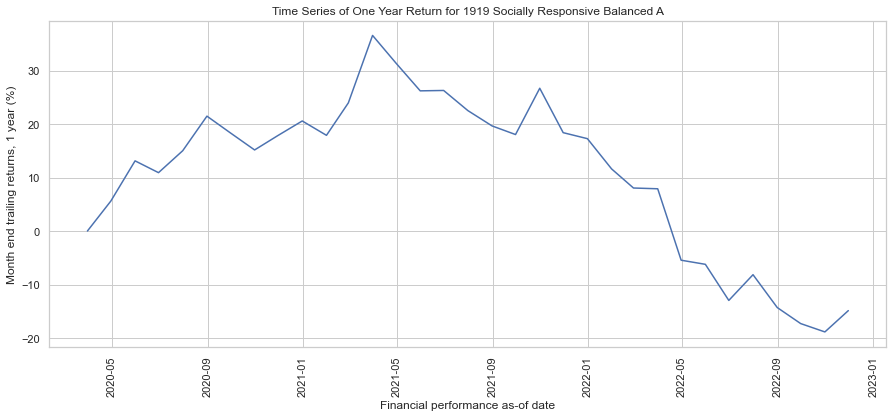

In [9]:
# Plotting this time series

sns.set(style='whitegrid')
plt.figure(figsize=(15, 6))

# Plot this time series using Seaborn's lineplot 
sns.lineplot(data=ts, 
             x='Financial performance as-of date', 
             y='Month end trailing returns, 1 year')
plt.xlabel('Financial performance as-of date')
plt.ylabel('Month end trailing returns, 1 year (%)')
plt.title('Time Series of One Year Return for 1919 Socially Responsive Balanced A')
plt.grid(True)

plt.xticks(rotation = 90)
plt.show()

In [10]:
# For validataion, reserve the last month as the test set, and all the rest are training set

train, test = ts.iloc[0:-1,:], ts.iloc[-1:,:]
test

,Shareclass_name,"Month end trailing returns, 1 year"
Financial performance as-of date,,
2022-11-30,1919 Socially Responsive Balanced A,-14.87273


In [11]:
train.shape

(32, 2)

In [12]:
# Fitting the ARIMA model

model = auto_arima(train['Month end trailing returns, 1 year'], seasonal=True, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
model_fit = model.fit(train['Month end trailing returns, 1 year'])
print(model_fit.summary)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=205.643, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=265.759, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=207.635, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=279.391, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=211.498, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=209.631, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=211.725, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 2.415 second

The best model is ARIMA(2,0,2)(0,0,0)[0] intercept, which indicate that in the best model the order of the autoregressive term is 2, which means that the value at time 't' is linearly dependent on the value at time 't-1' and 't-2. It also shows that the time series is stationary, and the order of the moving average term is 2 meaning that error at time 't' is influenced by the errors at times 't-1' and 't-2'. There is no seasonality detected. 

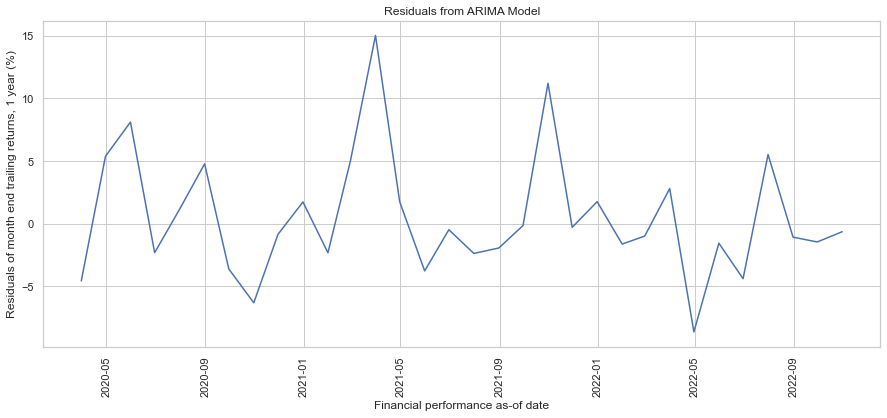

In [13]:
# Visualize the residuals of the model

residuals = model_fit.resid()

sns.set(style='whitegrid')
plt.figure(figsize=(15, 6))

# Plot this time series using Seaborn's lineplot 
sns.lineplot(data=residuals)
plt.xlabel('Financial performance as-of date')
plt.ylabel('Residuals of month end trailing returns, 1 year (%)')
plt.title('Residuals from ARIMA Model')
plt.grid(True)

plt.xticks(rotation = 90)
plt.show()

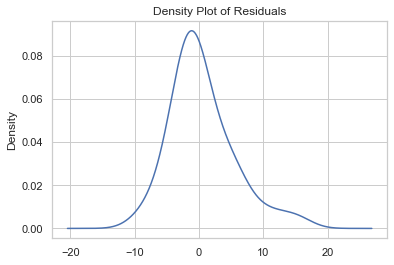

In [14]:
# Checking if the residuals look like a Gaussian distribution

residuals.plot(kind = 'kde')
plt.title('Density Plot of Residuals')
plt.show()

It looks pretty much like a Gaussian distribution.

In [15]:
# Predicting next month (to compare to the test set)

forecast, conf_int = model_fit.predict(n_periods=1, return_conf_int=True)

print(f"Forecasted value: {forecast[0]}")
print(f"95% Confidence interval: {conf_int[0]}")

Forecasted value: -19.70530685475803
95% Confidence interval: [-28.71696918 -10.69364453]


In [16]:
actual = test['Month end trailing returns, 1 year']
actual

Financial performance as-of date
2022-11-30   -14.87273
Name: Month end trailing returns, 1 year, dtype: float64

The actual value of -14.87273 is within the 95% confidence interval [-28.71696918 -10.69364453].

In [17]:
# Evaluate the model performance with MAE and MSE

mae = mean_absolute_error(actual, forecast)
mse = mean_squared_error(actual, forecast)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MAE: 4.832576854758031
MSE: 23.353799057143025


In [18]:
# Rolling cross-validation with leaving the last 1-5 months as test set

ts_array = ts['Month end trailing returns, 1 year']

for test_size in range(5, 0, -1):
    # Splitting the data into training and test sets
    train, test = ts_array[:-test_size], ts_array[-test_size:]
    
    # Fitting the ARIMA model on the training data
    model = auto_arima(train, seasonal=True, trace=False, 
                       error_action='ignore', suppress_warnings=True, 
                       stepwise=True)
    
    # Predicting the values for the test set
    predictions, _ = model.predict(n_periods=test_size, return_conf_int=True)

    # Calculating the MAE for the predictions
    mae = mean_absolute_error(test, predictions)
    print(f"Test Size {test_size} - MAE: {mae}") 
    
    # Calculating the RMSE for the predictions (RMSE is the square root of MSE, which is more interpretable)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"Test Size {test_size} - RMSE: {rmse}")  

Test Size 5 - MAE: 5.537189810999079
Test Size 5 - RMSE: 5.906160122640123
Test Size 4 - MAE: 9.413046850236148
Test Size 4 - RMSE: 9.628150221383224
Test Size 3 - MAE: 2.291317748263039
Test Size 3 - RMSE: 2.715787213624892
Test Size 2 - MAE: 4.6815301581509825
Test Size 2 - RMSE: 5.790806366123028
Test Size 1 - MAE: 4.832576854758031
Test Size 1 - RMSE: 4.832576854758031


Apparently, we can find the smallest MAE and RMSE when using a test size of 3, which leaves the last 3 months as the test set. It implies that the ARIMA best predicts the 3-month horizon. 

[Back to the Table of Contents](#0)

<a id="5"></a> 
##  Fitting the Random Forest Model with Features

In [19]:
# The data with features

df.head()

,Fund profile: Shareclass name,Fund profile: Ticker,Fund profile: Fund name,Fund profile: Asset manager,Fund profile: Shareclass type,Fund profile: Shareclass inception date,Fund profile: Category group,Fund profile: Oldest shareclass inception date,Fund profile: Shareclass tickers,Fund profile: Portfolio holdings as-of date,...,"Tobacco Free Funds: Tobacco producer, asset","Tobacco Free Funds: Tobacco-promoting entertainment company, count","Tobacco Free Funds: Tobacco-promoting entertainment company, weight","Tobacco Free Funds: Tobacco-promoting entertainment company, asset",current time,Shareclass name,Fund name,"Month end trailing returns, 1 year","Month end trailing returns, 3 year","Month end trailing returns, 5 year"
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,1919 Socially Responsive Balanced C,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1993-05-05,Allocation Funds,1992-11-06,"LMRNX, SESLX, SSIAX",2019-12-31,...,0,1,0.00546,1244893,20200414,1919 Socially Responsive Balanced C,1919 Socially Responsive Balanced Fund,-0.65016,6.37131,4.59848
2020-03-31,1919 Socially Responsive Balanced A,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,"LMRNX, SESLX, SSIAX",2019-12-31,...,0,1,0.00546,1244893,20200414,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,0.00352,7.13438,5.35168
2020-03-31,1919 Socially Responsive Balanced I,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,2008-07-24,Allocation Funds,1992-11-06,"LMRNX, SESLX, SSIAX",2019-12-31,...,0,1,0.00546,1244893,20200414,1919 Socially Responsive Balanced I,1919 Socially Responsive Balanced Fund,0.37831,7.46544,5.65125
2020-03-31,AB Discovery Value K,ABSKX,AB Discovery Value Fund,AllianceBernstein,Open-end mutual fund,2005-03-01,U.S. Equity Fund,2001-03-29,"ABASX, ABCSX, ABSIX, ABSKX, ABSRX, ABSZX, ABYSX",2020-02-29,...,0,0,0.00000,0,20200414,AB Discovery Value K,AB Discovery Value Fund,-32.02905,-10.69196,-3.87809
2020-03-31,AB Discovery Value R,ABSKX,AB Discovery Value Fund,AllianceBernstein,Open-end mutual fund,2003-11-03,U.S. Equity Fund,2001-03-29,"ABASX, ABCSX, ABSIX, ABSKX, ABSRX, ABSZX, ABYSX",2020-02-29,...,0,0,0.00000,0,20200414,AB Discovery Value R,AB Discovery Value Fund,-32.24253,-10.96269,-4.17165


In [20]:
df.shape

(172949, 90)

In [21]:
# There are two months systematically missing in all the time series
# Merging the imputed time series in the previous section with the dataframe including features

data_df = pd.merge(data.reset_index(), df.reset_index(), 
                  left_on = ['Financial performance as-of date', 'Shareclass_name'], 
                  right_on = ['Financial performance as-of date', 'Shareclass name'], 
                  how = 'outer') 
data_df = data_df.set_index(['Financial performance as-of date'])
data_df.head()

,Shareclass_name,"Month end trailing returns, 1 year_x",Fund profile: Shareclass name,Fund profile: Ticker,Fund profile: Fund name,Fund profile: Asset manager,Fund profile: Shareclass type,Fund profile: Shareclass inception date,Fund profile: Category group,Fund profile: Oldest shareclass inception date,...,"Tobacco Free Funds: Tobacco producer, asset","Tobacco Free Funds: Tobacco-promoting entertainment company, count","Tobacco Free Funds: Tobacco-promoting entertainment company, weight","Tobacco Free Funds: Tobacco-promoting entertainment company, asset",current time,Shareclass name,Fund name,"Month end trailing returns, 1 year_y","Month end trailing returns, 3 year","Month end trailing returns, 5 year"
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,1919 Socially Responsive Balanced A,0.00352,1919 Socially Responsive Balanced A,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,1.0,0.00546,1244893.0,20200414.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,0.00352,7.13438,5.35168
2020-04-30,1919 Socially Responsive Balanced A,5.60674,1919 Socially Responsive Balanced A,SESLX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,0.0,0.00000,0.0,20200519.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,5.60674,9.54694,7.22857
2020-05-31,1919 Socially Responsive Balanced A,13.11467,1919 Socially Responsive Balanced A,SSIAX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,0.0,0.00000,0.0,20200610.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,13.11467,10.65255,8.00301
2020-06-30,1919 Socially Responsive Balanced A,10.91060,1919 Socially Responsive Balanced A,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,0.0,0.00000,0.0,20200716.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,10.91060,11.54480,8.85987
2020-07-31,1919 Socially Responsive Balanced A,15.01209,1919 Socially Responsive Balanced A,SSIAX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,0.0,0.00000,0.0,20200811.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,15.01209,12.93448,9.55901


In [22]:
# Choosing the first share class

ts_df = data_df.loc[data_df['Shareclass_name'] == data_df['Shareclass_name'][0]]
ts_df.head()

,Shareclass_name,"Month end trailing returns, 1 year_x",Fund profile: Shareclass name,Fund profile: Ticker,Fund profile: Fund name,Fund profile: Asset manager,Fund profile: Shareclass type,Fund profile: Shareclass inception date,Fund profile: Category group,Fund profile: Oldest shareclass inception date,...,"Tobacco Free Funds: Tobacco producer, asset","Tobacco Free Funds: Tobacco-promoting entertainment company, count","Tobacco Free Funds: Tobacco-promoting entertainment company, weight","Tobacco Free Funds: Tobacco-promoting entertainment company, asset",current time,Shareclass name,Fund name,"Month end trailing returns, 1 year_y","Month end trailing returns, 3 year","Month end trailing returns, 5 year"
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,1919 Socially Responsive Balanced A,0.00352,1919 Socially Responsive Balanced A,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,1.0,0.00546,1244893.0,20200414.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,0.00352,7.13438,5.35168
2020-04-30,1919 Socially Responsive Balanced A,5.60674,1919 Socially Responsive Balanced A,SESLX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,0.0,0.00000,0.0,20200519.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,5.60674,9.54694,7.22857
2020-05-31,1919 Socially Responsive Balanced A,13.11467,1919 Socially Responsive Balanced A,SSIAX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,0.0,0.00000,0.0,20200610.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,13.11467,10.65255,8.00301
2020-06-30,1919 Socially Responsive Balanced A,10.91060,1919 Socially Responsive Balanced A,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,0.0,0.00000,0.0,20200716.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,10.91060,11.54480,8.85987
2020-07-31,1919 Socially Responsive Balanced A,15.01209,1919 Socially Responsive Balanced A,SSIAX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,...,0.0,0.0,0.00000,0.0,20200811.0,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund,15.01209,12.93448,9.55901


In [23]:
ts_df.shape

(33, 92)

In [24]:
# Checkingt the dimensions of the imputed time series in the previous section

ts.shape

(33, 2)

In [25]:
# Checking the target variables

df_target = ts_df.filter(like = 'returns')
df_target.head()

,"Month end trailing returns, 1 year_x","Month end trailing returns, 1 year_y","Month end trailing returns, 3 year","Month end trailing returns, 5 year"
Financial performance as-of date,,,,
2020-03-31,0.00352,0.00352,7.13438,5.35168
2020-04-30,5.60674,5.60674,9.54694,7.22857
2020-05-31,13.11467,13.11467,10.65255,8.00301
2020-06-30,10.91060,10.91060,11.54480,8.85987
2020-07-31,15.01209,15.01209,12.93448,9.55901


The main target is the "Month end trailing returns, 1 year", "Month end trailing returns, 1 year_x" is the imputed time series, while "Month end trailing returns, 1 year_y" is not imputed.

In [26]:
# Define the target

target = df_target['Month end trailing returns, 1 year_x']
target.head()

Financial performance as-of date
2020-03-31     0.00352
2020-04-30     5.60674
2020-05-31    13.11467
2020-06-30    10.91060
2020-07-31    15.01209
Name: Month end trailing returns, 1 year_x, dtype: float64

Next step, we need to select the features and preprocess the categorical and numeric features, respectively.

[Back to the Table of Contents](#0)

<a id="5.1"></a> 
### Preprocessing the Categorical Features

In [27]:
# Select the categorical features

categorical_columns = ts_df.select_dtypes(include=['object']).columns
ts_catx = ts_df[categorical_columns]

In [28]:
# Imputing the missing values with forward fill

ts_catx_filled = ts_catx.ffill()
ts_catx_filled.head()

,Shareclass_name,Fund profile: Shareclass name,Fund profile: Ticker,Fund profile: Fund name,Fund profile: Asset manager,Fund profile: Shareclass type,Fund profile: Shareclass inception date,Fund profile: Category group,Fund profile: Oldest shareclass inception date,Fund profile: Shareclass tickers,Fund profile: Portfolio holdings as-of date,Fossil Free Funds: Fossil fuel grade,Deforestation Free Funds: Deforestation grade,Gender Equality Funds: Gender equality grade,Gun Free Funds: Civilian firearm grade,Weapon Free Funds: Military weapon grade,Tobacco Free Funds: Tobacco grade,Shareclass name,Fund name
Financial performance as-of date,,,,,,,,,,,,,,,,,,,
2020-03-31,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced A,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,"LMRNX, SESLX, SSIAX",2019-12-31,A,B,B,A,A,B,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund
2020-04-30,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced A,SESLX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,"LMRNX, SESLX, SSIAX",2020-03-31,A,B,B,A,A,A,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund
2020-05-31,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced A,SSIAX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,"LMRNX, SESLX, SSIAX",2020-03-31,A,B,B,A,A,A,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund
2020-06-30,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced A,LMRNX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,"LMRNX, SESLX, SSIAX",2020-03-31,A,B,B,A,A,A,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund
2020-07-31,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced A,SSIAX,1919 Socially Responsive Balanced Fund,1919 Funds,Open-end mutual fund,1992-11-06,Allocation Funds,1992-11-06,"LMRNX, SESLX, SSIAX",2020-06-30,A,B,B,A,A,A,1919 Socially Responsive Balanced A,1919 Socially Responsive Balanced Fund


In [29]:
# Checking the number of unique values for each column, as it seems most columns have a single value

unique_counts = ts_catx_filled.nunique()
unique_counts

Shareclass_name                                    1
Fund profile: Shareclass name                      1
Fund profile: Ticker                               3
Fund profile: Fund name                            1
Fund profile: Asset manager                        1
Fund profile: Shareclass type                      1
Fund profile: Shareclass inception date            1
Fund profile: Category group                       1
Fund profile: Oldest shareclass inception date     1
Fund profile: Shareclass tickers                   1
Fund profile: Portfolio holdings as-of date       24
Fossil Free Funds: Fossil fuel grade               2
Deforestation Free Funds: Deforestation grade      1
Gender Equality Funds: Gender equality grade       3
Gun Free Funds: Civilian firearm grade             1
Weapon Free Funds: Military weapon grade           1
Tobacco Free Funds: Tobacco grade                  2
Shareclass name                                    1
Fund name                                     

In [30]:
# drop all the columns with only one unique value

ts_catx_useful = ts_catx_filled[unique_counts[unique_counts != 1].index]
ts_catx_useful.head()

,Fund profile: Ticker,Fund profile: Portfolio holdings as-of date,Fossil Free Funds: Fossil fuel grade,Gender Equality Funds: Gender equality grade,Tobacco Free Funds: Tobacco grade
Financial performance as-of date,,,,,
2020-03-31,LMRNX,2019-12-31,A,B,B
2020-04-30,SESLX,2020-03-31,A,B,A
2020-05-31,SSIAX,2020-03-31,A,B,A
2020-06-30,LMRNX,2020-03-31,A,B,A
2020-07-31,SSIAX,2020-06-30,A,B,A


In [31]:
# To simplify the first model attemp, we also drop the first two columns of the features, only keeping the ESG grade variables

ts_catx_esg = ts_catx_useful.filter(like = 'grade')
grade_columns = ts_catx_esg.columns

In [32]:
# Dealing with ordinal categories of the grade variables
# First define the shared ordinal categories

ordinal_categories = list(pd.Series(ts_catx_esg.values.ravel()).unique())
print(ordinal_categories)

['A', 'B', 'C', 'D']


In [33]:
# Create an instance of OrdinalEncoder with the shared categories
encoder = OrdinalEncoder(categories=[ordinal_categories] * len(grade_columns))

# Apply encoding to selected ordinal columns
ts_catx_esg[grade_columns] = encoder.fit_transform(ts_catx_esg[grade_columns])
ts_catx_esg.head()

,Fossil Free Funds: Fossil fuel grade,Gender Equality Funds: Gender equality grade,Tobacco Free Funds: Tobacco grade
Financial performance as-of date,,,
2020-03-31,0.0,1.0,1.0
2020-04-30,0.0,1.0,0.0
2020-05-31,0.0,1.0,0.0
2020-06-30,0.0,1.0,0.0
2020-07-31,0.0,1.0,0.0


[Back to the Table of Contents](#0)

<a id="5.2"></a> 
### Preparing the Numeric Features for Modeling

In [34]:
# Select the numeric features

numeric_columns = ts_df.select_dtypes(include=['float', 'int']).columns
ts_num = ts_df[numeric_columns]
ts_num.head()

,"Month end trailing returns, 1 year_x",Fund profile: Fund net assets,Fund profile: Percent rated,"Fossil Free Funds: Fossil fuel holdings, count","Fossil Free Funds: Fossil fuel holdings, weight","Fossil Free Funds: Fossil fuel holdings, asset","Fossil Free Funds: Carbon Underground 200, count","Fossil Free Funds: Carbon Underground 200, weight","Fossil Free Funds: Carbon Underground 200, asset","Fossil Free Funds: Coal industry, count",...,"Tobacco Free Funds: Tobacco producer, count","Tobacco Free Funds: Tobacco producer, weight","Tobacco Free Funds: Tobacco producer, asset","Tobacco Free Funds: Tobacco-promoting entertainment company, count","Tobacco Free Funds: Tobacco-promoting entertainment company, weight","Tobacco Free Funds: Tobacco-promoting entertainment company, asset",current time,"Month end trailing returns, 1 year_y","Month end trailing returns, 3 year","Month end trailing returns, 5 year"
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,0.00352,228010406.0,0.631210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.00546,1244893.0,20200414.0,0.00352,7.13438,5.35168
2020-04-30,5.60674,209290783.0,0.617603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,20200519.0,5.60674,9.54694,7.22857
2020-05-31,13.11467,209290783.0,0.617603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,20200610.0,13.11467,10.65255,8.00301
2020-06-30,10.91060,209290783.0,0.617603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,20200716.0,10.91060,11.54480,8.85987
2020-07-31,15.01209,276186822.0,0.637068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,20200811.0,15.01209,12.93448,9.55901


In [35]:
# Here, impute all the missing values by calculate the mean of the previous and after values 

# Checking the missing values
print(ts_num.isna().sum().max())
# Only missing values are the two months without records

ts_num_ffill = ts_num.ffill()
ts_num_bfill = ts_num.bfill()
ts_num_filled = ts_num.fillna((ts_num_ffill + ts_num_bfill) / 2)
ts_num_filled.isna().sum().max()

2


0

In [36]:
# Removing the target variables

ts_numx = ts_num_filled.drop(columns = df_target.columns)
ts_numx.head()

,Fund profile: Fund net assets,Fund profile: Percent rated,"Fossil Free Funds: Fossil fuel holdings, count","Fossil Free Funds: Fossil fuel holdings, weight","Fossil Free Funds: Fossil fuel holdings, asset","Fossil Free Funds: Carbon Underground 200, count","Fossil Free Funds: Carbon Underground 200, weight","Fossil Free Funds: Carbon Underground 200, asset","Fossil Free Funds: Coal industry, count","Fossil Free Funds: Coal industry, weight",...,"Weapon Free Funds: Cluster munitions / landmines, count","Weapon Free Funds: Cluster munitions / landmines, weight","Weapon Free Funds: Cluster munitions / landmines, asset","Tobacco Free Funds: Tobacco producer, count","Tobacco Free Funds: Tobacco producer, weight","Tobacco Free Funds: Tobacco producer, asset","Tobacco Free Funds: Tobacco-promoting entertainment company, count","Tobacco Free Funds: Tobacco-promoting entertainment company, weight","Tobacco Free Funds: Tobacco-promoting entertainment company, asset",current time
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,228010406.0,0.631210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00546,1244893.0,20200414.0
2020-04-30,209290783.0,0.617603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,20200519.0
2020-05-31,209290783.0,0.617603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,20200610.0
2020-06-30,209290783.0,0.617603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,20200716.0
2020-07-31,276186822.0,0.637068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,20200811.0


In [37]:
len(ts_numx.columns)

69

The number of features is too large, need to do feature selection in the modeling steps.

In [38]:
# Firstly, checking whether there are constant variables for this time series

num_counts = ts_numx.nunique()
print(num_counts[num_counts != 1])

Fund profile: Fund net assets                                                            25
Fund profile: Percent rated                                                              25
Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)             30
Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue)              29
Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)                          30
Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e)                      30
Fossil Free Funds: Carbon footprint portfolio coverage by market value weight            28
Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles    23
Fossil Free Funds: Clean200, count                                                        5
Fossil Free Funds: Clean200, weight                                                      25
Fossil Free Funds: Clean200, asset                                              

In [39]:
# Removing all the constant variables

ts_numx_useful = ts_numx[num_counts[num_counts != 1].index]
ts_numx_useful.shape

(33, 23)

Now, we have 23 variant features left. These are what we will include in the modeling.

In [40]:
ts_numx_useful.head()

,Fund profile: Fund net assets,Fund profile: Percent rated,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested),Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue),Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e),Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e),Fossil Free Funds: Carbon footprint portfolio coverage by market value weight,Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles,"Fossil Free Funds: Clean200, count","Fossil Free Funds: Clean200, weight",...,"Deforestation Free Funds: Deforestation-risk consumer brand, count","Deforestation Free Funds: Deforestation-risk consumer brand, weight","Deforestation Free Funds: Deforestation-risk consumer brand, asset",Gender Equality Funds: Gender equality group ranking,Gender Equality Funds: Count of holdings with Equileap gender equality scores,Gender Equality Funds: Weight of holdings with Equileap gender equality scores,"Tobacco Free Funds: Tobacco-promoting entertainment company, count","Tobacco Free Funds: Tobacco-promoting entertainment company, weight","Tobacco Free Funds: Tobacco-promoting entertainment company, asset",current time
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,228010406.0,0.631210,15.01,38.60,5420.70,13702.81,0.631208,0.837209,5.0,0.077585,...,7.0,0.113257,25823739.0,75.0,42.0,0.631210,1.0,0.00546,1244893.0,20200414.0
2020-04-30,209290783.0,0.617603,11.63,30.88,3941.25,8406.47,0.617601,0.813953,5.0,0.082457,...,7.0,0.119456,25001099.0,74.0,41.0,0.617603,0.0,0.00000,0.0,20200519.0
2020-05-31,209290783.0,0.617603,11.68,30.94,4052.61,8420.15,0.603049,0.833333,5.0,0.082457,...,7.0,0.119456,25001099.0,72.0,41.0,0.617603,0.0,0.00000,0.0,20200610.0
2020-06-30,209290783.0,0.617603,11.47,30.40,3981.71,9516.87,0.603049,0.833333,5.0,0.082457,...,7.0,0.119456,25001099.0,74.0,41.0,0.617603,0.0,0.00000,0.0,20200716.0
2020-07-31,276186822.0,0.637068,10.50,29.01,4681.54,11743.12,0.623653,0.800000,5.0,0.080249,...,7.0,0.118701,33020946.0,74.0,43.0,0.637068,0.0,0.00000,0.0,20200811.0


In [41]:
# 'current time' is also useless

ts_numx_f = ts_numx_useful.drop(columns = 'current time')
features = ts_numx_f.columns
features

Index(['Fund profile: Fund net assets', 'Fund profile: Percent rated',
       'Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)',
       'Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue)',
       'Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)',
       'Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e)',
       'Fossil Free Funds: Carbon footprint portfolio coverage by market value weight',
       'Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles',
       'Fossil Free Funds: Clean200, count',
       'Fossil Free Funds: Clean200, weight',
       'Fossil Free Funds: Clean200, asset',
       'Deforestation Free Funds: Deforestation-risk financier, weight',
       'Deforestation Free Funds: Deforestation-risk financier, asset',
       'Deforestation Free Funds: Deforestation-risk consumer brand, count',
       'Deforestation Free Funds: Deforestation-risk consumer 

In [42]:
# Adding the lagging and moving average variables as features
lag = 3
ts_numx_extd = ts_numx_f.copy()

# For each numeric feature, generate 3 new features: 2 lagging feature and 1 moving average feature
# Lagging variables
for feature in features:
    for i in range(1, lag):
        ts_numx_extd[f'{feature}_lag_{i}'] =  ts_numx_f[feature].shift(i)
    # Movig average variables:
    ts_numx_extd[f'{feature}_moving_avg_{lag}'] =  ts_numx_f[feature].rolling(window = lag).mean()

# For the main target variable, generate 3 features: 2 lagging target and 1 moving average of the target
# Lagging variables
for i in range(1, lag):
    ts_numx_extd[f'target_lag_{i}'] =  ts_num_filled['Month end trailing returns, 1 year_x'].shift(i)
# Moving average variable:
ts_numx_extd[f'target_moving_avg_{lag}'] = ts_num_filled['Month end trailing returns, 1 year_x'].rolling(window = lag).mean()

# print the lagging features

ts_numx_extd.filter(like = 'lag').head()

,Fund profile: Fund net assets_lag_1,Fund profile: Fund net assets_lag_2,Fund profile: Percent rated_lag_1,Fund profile: Percent rated_lag_2,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)_lag_1,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)_lag_2,Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue)_lag_1,Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue)_lag_2,Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)_lag_1,Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)_lag_2,...,Gender Equality Funds: Weight of holdings with Equileap gender equality scores_lag_1,Gender Equality Funds: Weight of holdings with Equileap gender equality scores_lag_2,"Tobacco Free Funds: Tobacco-promoting entertainment company, count_lag_1","Tobacco Free Funds: Tobacco-promoting entertainment company, count_lag_2","Tobacco Free Funds: Tobacco-promoting entertainment company, weight_lag_1","Tobacco Free Funds: Tobacco-promoting entertainment company, weight_lag_2","Tobacco Free Funds: Tobacco-promoting entertainment company, asset_lag_1","Tobacco Free Funds: Tobacco-promoting entertainment company, asset_lag_2",target_lag_1,target_lag_2
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,228010406.0,NaN,0.631210,NaN,15.01,NaN,38.60,NaN,5420.70,NaN,...,0.631210,NaN,1.0,NaN,0.00546,NaN,1244893.0,NaN,0.00352,NaN
2020-05-31,209290783.0,228010406.0,0.617603,0.631210,11.63,15.01,30.88,38.60,3941.25,5420.70,...,0.617603,0.631210,0.0,1.0,0.00000,0.00546,0.0,1244893.0,5.60674,0.00352
2020-06-30,209290783.0,209290783.0,0.617603,0.617603,11.68,11.63,30.94,30.88,4052.61,3941.25,...,0.617603,0.617603,0.0,0.0,0.00000,0.00000,0.0,0.0,13.11467,5.60674
2020-07-31,209290783.0,209290783.0,0.617603,0.617603,11.47,11.68,30.40,30.94,3981.71,4052.61,...,0.617603,0.617603,0.0,0.0,0.00000,0.00000,0.0,0.0,10.91060,13.11467


In [43]:
# print the moving average features

ts_numx_extd.filter(like = 'moving').head()

,Fund profile: Fund net assets_moving_avg_3,Fund profile: Percent rated_moving_avg_3,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)_moving_avg_3,Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue)_moving_avg_3,Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)_moving_avg_3,Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e)_moving_avg_3,Fossil Free Funds: Carbon footprint portfolio coverage by market value weight_moving_avg_3,Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles_moving_avg_3,"Fossil Free Funds: Clean200, count_moving_avg_3","Fossil Free Funds: Clean200, weight_moving_avg_3",...,"Deforestation Free Funds: Deforestation-risk consumer brand, count_moving_avg_3","Deforestation Free Funds: Deforestation-risk consumer brand, weight_moving_avg_3","Deforestation Free Funds: Deforestation-risk consumer brand, asset_moving_avg_3",Gender Equality Funds: Gender equality group ranking_moving_avg_3,Gender Equality Funds: Count of holdings with Equileap gender equality scores_moving_avg_3,Gender Equality Funds: Weight of holdings with Equileap gender equality scores_moving_avg_3,"Tobacco Free Funds: Tobacco-promoting entertainment company, count_moving_avg_3","Tobacco Free Funds: Tobacco-promoting entertainment company, weight_moving_avg_3","Tobacco Free Funds: Tobacco-promoting entertainment company, asset_moving_avg_3",target_moving_avg_3
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-31,2.155307e+08,0.622139,12.773333,33.473333,4471.520000,10176.476667,0.617286,0.828165,5.0,0.080833,...,7.0,0.117390,2.527531e+07,73.666667,41.333333,0.622139,0.333333,0.00182,414964.333333,6.241643
2020-06-30,2.092908e+08,0.617603,11.593333,30.740000,3991.856667,8781.163333,0.607900,0.826873,5.0,0.082457,...,7.0,0.119456,2.500110e+07,73.333333,41.000000,0.617603,0.000000,0.00000,0.000000,9.877337
2020-07-31,2.315895e+08,0.624091,11.216667,30.116667,4238.620000,9893.380000,0.609917,0.822222,5.0,0.081721,...,7.0,0.119204,2.767438e+07,73.333333,41.666667,0.624091,0.000000,0.00000,0.000000,13.012453


We are planning to use tree-based methods in the modeling, so it is not necessary to scale features. However, for the convenience to try other methods as well, we scale all the numberic features by standardization.

In [44]:
# Scaling the numeric features by standardization

scaler = StandardScaler()
ts_numx_extd_scaled = pd.DataFrame(scaler.fit_transform(ts_numx_extd), columns = ts_numx_extd.columns, index = ts_numx_extd.index)

ts_numx_extd_scaled.head()

,Fund profile: Fund net assets,Fund profile: Percent rated,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested),Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue),Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e),Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e),Fossil Free Funds: Carbon footprint portfolio coverage by market value weight,Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles,"Fossil Free Funds: Clean200, count","Fossil Free Funds: Clean200, weight",...,"Tobacco Free Funds: Tobacco-promoting entertainment company, count_moving_avg_3","Tobacco Free Funds: Tobacco-promoting entertainment company, weight_lag_1","Tobacco Free Funds: Tobacco-promoting entertainment company, weight_lag_2","Tobacco Free Funds: Tobacco-promoting entertainment company, weight_moving_avg_3","Tobacco Free Funds: Tobacco-promoting entertainment company, asset_lag_1","Tobacco Free Funds: Tobacco-promoting entertainment company, asset_lag_2","Tobacco Free Funds: Tobacco-promoting entertainment company, asset_moving_avg_3",target_lag_1,target_lag_2,target_moving_avg_3
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,-1.552135,-1.192333,-0.774008,1.175193,-1.175209,-1.140623,-0.971475,0.628430,-1.205525,-1.285771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,-1.632049,-1.911951,-1.056941,0.672655,-1.284141,-1.284684,-1.109438,0.478758,-1.205525,-1.136211,...,NaN,-1.085583,NaN,NaN,-1.492084,NaN,NaN,-0.793381,NaN,NaN
2020-05-31,-1.632049,-1.911951,-1.052756,0.676560,-1.275942,-1.284312,-1.256982,0.603485,-1.205525,-1.136211,...,-1.905959,-2.188347,-1.074844,-2.030778,-1.812155,-1.470568,-1.851976,-0.405754,-0.914942,-0.398267
2020-06-30,-1.632049,-1.911951,-1.070335,0.641409,-1.281162,-1.254481,-1.256982,0.603485,-1.205525,-1.136211,...,-3.064484,-2.188347,-2.160822,-2.429996,-1.812155,-1.785617,-1.964275,0.113641,-0.503058,-0.138906
2020-07-31,-1.346469,-0.882537,-1.151532,0.550926,-1.229634,-1.193927,-1.048079,0.388955,-1.205525,-1.203986,...,-3.064484,-2.188347,-2.160822,-2.429996,-1.812155,-1.785617,-1.964275,-0.038836,0.048838,0.084746


[Back to the Table of Contents](#0)

<a id="5.3"></a> 
### Model Fitting, Cross-validation, and Feature Selection

In [45]:
# Combining the categorical and numeric features, as well as target

model_data = ts_numx_extd_scaled.join(ts_catx_esg).join(target)
model_data.head()

,Fund profile: Fund net assets,Fund profile: Percent rated,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested),Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue),Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e),Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e),Fossil Free Funds: Carbon footprint portfolio coverage by market value weight,Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles,"Fossil Free Funds: Clean200, count","Fossil Free Funds: Clean200, weight",...,"Tobacco Free Funds: Tobacco-promoting entertainment company, asset_lag_1","Tobacco Free Funds: Tobacco-promoting entertainment company, asset_lag_2","Tobacco Free Funds: Tobacco-promoting entertainment company, asset_moving_avg_3",target_lag_1,target_lag_2,target_moving_avg_3,Fossil Free Funds: Fossil fuel grade,Gender Equality Funds: Gender equality grade,Tobacco Free Funds: Tobacco grade,"Month end trailing returns, 1 year_x"
Financial performance as-of date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,-1.552135,-1.192333,-0.774008,1.175193,-1.175209,-1.140623,-0.971475,0.628430,-1.205525,-1.285771,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.00352
2020-04-30,-1.632049,-1.911951,-1.056941,0.672655,-1.284141,-1.284684,-1.109438,0.478758,-1.205525,-1.136211,...,-1.492084,NaN,NaN,-0.793381,NaN,NaN,0.0,1.0,0.0,5.60674
2020-05-31,-1.632049,-1.911951,-1.052756,0.676560,-1.275942,-1.284312,-1.256982,0.603485,-1.205525,-1.136211,...,-1.812155,-1.470568,-1.851976,-0.405754,-0.914942,-0.398267,0.0,1.0,0.0,13.11467
2020-06-30,-1.632049,-1.911951,-1.070335,0.641409,-1.281162,-1.254481,-1.256982,0.603485,-1.205525,-1.136211,...,-1.812155,-1.785617,-1.964275,0.113641,-0.503058,-0.138906,0.0,1.0,0.0,10.91060
2020-07-31,-1.346469,-0.882537,-1.151532,0.550926,-1.229634,-1.193927,-1.048079,0.388955,-1.205525,-1.203986,...,-1.812155,-1.785617,-1.964275,-0.038836,0.048838,0.084746,0.0,1.0,0.0,15.01209


In [46]:
# Firstly, drop the first two rows with NaNs

model_data.dropna(inplace = True)
model_data.shape

(31, 95)

In [47]:
# Tain/Test split, using the last 3 months for testing

train = model_data.iloc[:-3]
test = model_data.iloc[-3:]

test.shape

(3, 95)

In [48]:
# Define target and feature variables

target_main = 'Month end trailing returns, 1 year_x'
features_full = train.columns[train.columns != 'Month end trailing returns, 1 year_x']

len(features_full)

94

In [49]:
# Modeling using Random Forest

model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(train[features_full], train[target_main])

RandomForestRegressor(random_state=42)

In [50]:
# Making predictions

predictions_RF = model.predict(test[features_full])
predictions_RF

array([-10.4288199, -10.668903 , -11.6494488])

In [51]:
# Calculate error

MAE_RF = mean_absolute_error(test[target_main], predictions_RF)
print(f"Mean Absolute Error: {MAE_RF: .2f}")
MSE_RF = mean_squared_error(test[target_main], predictions_RF)
print(f"Mean Squared Error: {MSE_RF: .2f}")

Mean Absolute Error:  6.09
Mean Squared Error:  41.52


In [52]:
RMSE_RF = np.sqrt(MSE_RF)
print(f"Root Mean Squared Error: {RMSE_RF: .2f}")

Root Mean Squared Error:  6.44


Using all the features, the Random Forest model performs worse than the ARIMA. We only used one time series here, which is quite short. Whit such a few data points, the machine learning approaches are easily overfit. However, the whole dataset has thousands of time series. In the next step in the modeling of the whole dataset, we may see performance improvement. 

Here, we can still figure out what features are important and whether the cross-validation with feature selection can improve the model performance for this limited data.

In [53]:
# Feature importance

importances = model.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': features_full,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Setting display options to prevent truncation
pd.set_option('display.max_columns', None)  # Prevent column truncation
pd.set_option('display.width', None)        # Prevent row truncation
pd.set_option('display.max_colwidth', None) # Prevent cell truncation

feature_importances_df.head(15)

,Feature,Importance
90,target_moving_avg_3,0.215493
5,Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e),0.076112
2,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested),0.073921
30,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)_moving_avg_3,0.067772
28,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)_lag_1,0.062259
88,target_lag_1,0.055029
37,Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e)_lag_1,0.049105
36,Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)_moving_avg_3,0.041437
4,Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e),0.037290
34,Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)_lag_1,0.034978


It shows that the target related features and fossil fuel related features are the most important in this model.

In [54]:
# Using Recursive Feature Elimination (RFE) coupled with cross-validation (RFECV), we search for an optimal number of features

X = model_data.drop(axis = 1, columns = ['Month end trailing returns, 1 year_x'])
y = model_data['Month end trailing returns, 1 year_x']

estimator = RandomForestRegressor(n_estimators = 100, random_state = 42)

tscv = TimeSeriesSplit(n_splits = 5)
selector = RFECV(estimator, step = 1, cv = tscv)

selector = selector.fit(X, y)

print(f"Optimal number of features: {selector.n_features_}")

Optimal number of features: 5


In [55]:
# Print ranking of features

feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking':selector.ranking_
}).sort_values(by='Ranking')

feature_ranking.head()

,Feature,Ranking
35,Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)_lag_2,1
88,target_lag_1,1
2,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested),1
90,target_moving_avg_3,1
30,Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)_moving_avg_3,1


The optimal number of features is 5. 
The 5 most important features are: 
- The total financed emissions scope 1 + 2 (tCO2e) with a 2-month lag, 
- The target variable with 1-month lag, 
- The relative carbon footprint (tonnes CO2 per 1M USD invested),
- The 3-month moving average of the target variable, 
- The 3-month moving average of the relative carbon footprint (tonnes CO2 per 1M USD invested).	

In [56]:
# Transform data to only use important features

X_selected = selector.transform(X)

In [57]:
# Train/Test split

test_size = 3
train_size = len(y) - test_size
print(train_size)

X_train, X_test = X_selected[:train_size], X_selected[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

28


In [58]:
# Modeling with important features

model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [59]:
# Make predictions

y_pred = model.predict(X_test)
y_pred

array([-11.9593199, -12.1698695, -12.1698695])

In [60]:
# Evaluate the model performance on test set

MAE = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {MAE: .2f}")
MSE = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {MSE: .2f}")

Mean Absolute Error:  4.91
Mean Squared Error:  26.82


In [61]:
RMSE = np.sqrt(MSE)
print(f"Root Mean Squared Error: {RMSE: .2f}")

Root Mean Squared Error:  5.18


The model with most important features performs better than the model with all the features. However, it still under-performs the ARIMA model. In the next section, we will model for all the time series.

[Back to the Table of Contents](#0)

<a id="6"></a> 
## Summary

In this section, we preprocessed the data and performed the ARIMA and Random Forest model on a subset of the data that associate with one of the thousands of share classes. The ARIMA model is performed on the time series data of the month end trailing return of one year, while the Random Forest model treats the time series data as the target and model it with the available categorical and numeric features.

Using the ARIMA model, we find that in the best model the order of the autoregressive term is 2 and the order of the moving average term is 2. The data is stationary and does not have evident seasonality. The best prediction horizon is 3-month, with mean absolute error (MAE) of 2.29 and root mean squared error (RMSE) of 2.72 using the best model.

Using the Random Forest model, we firstly generate some lagging and moving average features based on the numeric features as well as the target varible. This is to include the time dependency in the data, as the Random Forest model does not account for the order of the data. Then, we combined all these derived features and the original numeric features and scale them with standardization. Modeling with all these features as well as the transformed categorical features, we find the model performance is lower than the ARIMA model for the 3-month prediction horizon, with MAE of 6.09 and RMSE of 6.44. This could contribute to the limit of observations and the noise introduced by too many features. 

In order to improve the model performance by eliminating low importance features, we performed the feature selection using the Recursive Feature Elimination (RFE) coupled with cross-validation. The results showed that for this subset of data, The optimal number of features is five, and the five most important features are the total financed emissions scope 1 + 2 (tCO2e) with a 2-month lag, the target variable with 1-month lag, the relative carbon footprint (tonnes CO2 per 1M USD invested), the 3-month moving average of the target variable, and the 3-month moving average of the relative carbon footprint (tonnes CO2 per 1M USD invested). If only using these most important features, the model performance is improved, with MAE of 4.91 and RMSE of 5.18. But it still slightly underperforms in the 3-month horizon compared to the ARIMA.

In the next step, we will extend the modeling to the whole dataset with thousands of share classes. With the larger dataset, we can use more modeling approaches as well.

[Back to the Table of Contents](#0)